In [1]:
import os
import re
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from collections import Counter


CANONICAL_SKILLS = [
    "python", "r", "sql", "excel", "machine learning", "deep learning", "nlp",
    "tensorflow", "pytorch", "aws", "azure", "gcp", "java", "c++", "spark",
    "hadoop", "tableau", "power bi", "communication", "statistics", "regression",
    "classification", "computer vision", "data visualization", "linux"
]

def normalize_text(s):
    if pd.isna(s):
        return ""
    return re.sub(r'\s+', ' ', str(s).strip()).lower()

def extract_skills_from_text(text, extra_skill_list=None):
    text_norm = normalize_text(text)
    found = set()
    skills_to_check = CANONICAL_SKILLS.copy()
    if extra_skill_list:
        skills_to_check += [s.lower() for s in extra_skill_list]
    # simple word-boundary search for each skill phrase
    for skill in skills_to_check:
        # escape skill for regex; match whole words or phrases
        pat = r'\b' + re.escape(skill.lower()) + r'\b'
        if re.search(pat, text_norm):
            found.add(skill.lower())
    # additional heuristics: capture words like "python3" or "python," etc.
    # split text into tokens and add tokens that look like skill names
    tokens = re.findall(r'[a-z\+\#\d\-\.]+', text_norm)
    # optionally add tokens of length 2-20 that aren't stopwords
    # but to keep it conservative, only include tokens present in skills_to_check
    return sorted(found)


In [2]:
def load_jobs_from_csv(path):
    """
    Load a CSV/Excel file that contains job data.
    Expected columns (any subset): job_title, company, location, job_description, skills
    Returns a dataframe with columns: title, location, role, description, skills_raw
    """
    ext = os.path.splitext(path)[1].lower()
    if ext in ['.xlsx', '.xls']:
        df = pd.read_excel(path)
    else:
        df = pd.read_csv(path)

    # try to guess common column names
    cols = [c.lower() for c in df.columns]
    col_map = {}
    for c in df.columns:
        lc = c.lower()
        if 'title' in lc and 'job' in lc or lc == 'job_title' or 'position' in lc:
            col_map[c] = 'title'
        elif 'company' in lc:
            col_map[c] = 'company'
        elif 'location' in lc:
            col_map[c] = 'location'
        elif 'description' in lc or 'jd' in lc or 'detail' in lc:
            col_map[c] = 'description'
        elif 'skill' in lc:
            col_map[c] = 'skills_raw'
        elif 'role' in lc:
            col_map[c] = 'role'
    # rename discovered columns
    df = df.rename(columns=col_map)
    # ensure baseline columns exist
    for c in ['title','company','location','description','skills_raw','role']:
        if c not in df.columns:
            df[c] = np.nan
    # unify and return
    df2 = df[['title','company','location','description','skills_raw','role']].copy()
    # normalize text fields
    df2['title'] = df2['title'].astype(str)
    df2['location'] = df2['location'].astype(str)
    df2['description'] = df2['description'].astype(str)
    df2['skills_raw'] = df2['skills_raw'].astype(str)
    return df2


In [ ]:
def parse_saved_html_folder(folder_path, file_pattern="*.html"):
    """
    Parse saved job-listing HTML files in folder_path.
    This is for locally saved HTML pages (you saved them manually in browser).
    Returns DataFrame with title, location, description (as available).
    NOTE: HTML structures vary; you may need to adapt selectors.
    """
    rows = []
    files = glob.glob(os.path.join(folder_path, file_pattern))
    print(f"Found {len(files)} HTML files in folder.")
    for f in files:
        with open(f, 'r', encoding='utf-8', errors='ignore') as fh:
            html = fh.read()
        soup = BeautifulSoup(html, 'html.parser')
        # Common attempt: look for job cards
        # These selectors are examples; adjust to your saved HTML structure.
        job_cards = soup.select('li')  # fallback: all list items
        # Try more targeted selects
        if not job_cards:
            job_cards = soup.find_all(attrs={"class": re.compile("job|card|result", re.I)})
        # If still many, just attempt to extract big text blocks
        page_text = soup.get_text(separator=' ', strip=True)
        # Best-effort parsing:
        # Try to find title/location pairs in the file using heuristics
        # Heuristic: find patterns like "Title • Company • Location" or "Location\nTitle"
        # This is intentionally generic; you should inspect one saved HTML to improve selectors.
        # For now we create a single row with whole page text (useful if file is single job page)
        rows.append({
            'title': soup.find('h1').get_text(strip=True) if soup.find('h1') else "",
            'company': (soup.find('h2').get_text(strip=True) if soup.find('h2') else ""),
            'location': (soup.find(attrs={"class": re.compile("location", re.I)}) .get_text(strip=True)
                         if soup.find(attrs={"class": re.compile("location", re.I)}) else ""),
            'description': page_text,
            'skills_raw': ""
        })
    df = pd.DataFrame(rows)
    return df


In [5]:
def build_skill_columns(df, extra_skills=None):
    """
    Input df must have 'title' and 'description' and optional 'skills_raw' and 'role' columns.
    This will produce df['skills'] as a list of skill strings (lowercase) per row.
    """
    skill_lists = []
    for idx, row in df.iterrows():
        text_to_scan = " ".join([
            str(row.get('title','') or ''),
            str(row.get('description','') or ''),
            str(row.get('skills_raw','') or '')
        ])
        found = extract_skills_from_text(text_to_scan, extra_skill_list=extra_skills)
        skill_lists.append(found)
    df = df.copy()
    df['skills'] = skill_lists
    # create exploded table for counting
    df_exploded = df.explode('skills').reset_index(drop=True)
    # some rows might have empty skills -> drop
    df_exploded = df_exploded[df_exploded['skills'].notna() & (df_exploded['skills'] != "")]
    return df, df_exploded


In [6]:
def top_skills_by_city(df_exploded, top_n=10):
    """
    df_exploded should have columns: 'location', 'skills', 'role', 'count' optional
    We'll count occurrences of skill mentions per location.
    """
    # unify location to city-level (strip after comma if multiple parts)
    df_exploded['city'] = df_exploded['location'].apply(lambda s: normalize_text(s).split(',')[0] if pd.notna(s) else 'unknown')
    counts = df_exploded.groupby(['city','skills']).size().reset_index(name='count')
    # get top skills overall for filtering columns
    top_skills_overall = counts.groupby('skills')['count'].sum().sort_values(ascending=False).head(top_n).index.tolist()
    # pivot for heatmap (cities x skills)
    pivot = counts[counts['skills'].isin(top_skills_overall)].pivot_table(index='skills', columns='city', values='count', aggfunc='sum', fill_value=0)
    return pivot, top_skills_overall

def plot_heatmap(matrix_df, title="Heatmap", figsize=(12,6), cmap="YlGnBu"):
    plt.figure(figsize=figsize)
    sns.heatmap(matrix_df, annot=True, fmt="g", cmap=cmap)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def skill_vs_role_matrix(df_exploded):
    """
    Build Skill x Role matrix. If role missing, try infer from title using heuristics.
    """
    # try to ensure role column exists
    if 'role' not in df_exploded.columns or df_exploded['role'].isna().all():
        # simple heuristic: look for common role words in title
        roles_guess = []
        for t in df_exploded['title'].fillna(''):
            tl = normalize_text(t)
            role_guess = None
            if 'data scientist' in tl: role_guess = 'Data Scientist'
            elif 'data analyst' in tl: role_guess = 'Data Analyst'
            elif 'machine learning' in tl or 'ml engineer' in tl: role_guess = 'ML Engineer'
            elif 'software' in tl or 'developer' in tl: role_guess = 'Software Engineer'
            else: role_guess = 'Other'
            roles_guess.append(role_guess)
        df_exploded['role'] = roles_guess

    pivot_role = df_exploded.pivot_table(index='skills', columns='role', values='title', aggfunc='count', fill_value=0)
    return pivot_role

def job_demand_recommendation(df_exploded, top_n_skills=3):
    """
    For each city, recommend top N in-demand skills (by count).
    Also return top N skills overall.
    """
    df_exploded['city'] = df_exploded['location'].apply(lambda s: normalize_text(s).split(',')[0] if pd.notna(s) else 'unknown')
    city_skill_counts = df_exploded.groupby(['city','skills']).size().reset_index(name='count')
    # top skills per city
    top_per_city = city_skill_counts.sort_values(['city','count'], ascending=[True, False]).groupby('city').head(top_n_skills)
    # top overall
    top_overall = city_skill_counts.groupby('skills')['count'].sum().sort_values(ascending=False).head(top_n_skills).reset_index()
    return top_per_city, top_overall


In [7]:
def export_results_to_excel(out_path, pivot_city, pivot_role, top_per_city, top_overall, df_raw=None):
    with pd.ExcelWriter(out_path, engine='openpyxl') as writer:
        pivot_city.to_excel(writer, sheet_name='TopSkills_By_City')
        pivot_role.to_excel(writer, sheet_name='Skill_vs_Role')
        top_per_city.to_excel(writer, sheet_name='TopSkills_Per_City', index=False)
        top_overall.to_excel(writer, sheet_name='TopSkills_Overall', index=False)
        if df_raw is not None:
            df_raw.to_excel(writer, sheet_name='RawData', index=False)
    print("Exported analysis to:", out_path)

# export to excel


In [ ]:
#putting all together
def run_analysis_from_csv(csv_path):
    df = load_jobs_from_csv(csv_path)
    df_clean, df_exploded = build_skill_columns(df)
    # If df_exploded empty, warn user
    if df_exploded.empty:
        print("No skills detected from dataset. Please check 'skills' or 'description' columns or expand CANONICAL_SKILLS.")
        return
    pivot_city, top_sk = top_skills_by_city(df_exploded, top_n=10)
    plot_heatmap(pivot_city, title="Top-10 Skills by City (counts)")
    pivot_role = skill_vs_role_matrix(df_exploded)
    plot_heatmap(pivot_role, title="Skill vs Role Matrix", cmap="OrRd")
    top_per_city, top_overall = job_demand_recommendation(df_exploded, top_n_skills=5)
    print("\nTop skills overall:\n", top_overall)
    print("\nTop skills per city (sample):\n", top_per_city.head(20))
    # Export
    export_results_to_excel("linkedin_skill_analysis.xlsx", pivot_city, pivot_role, top_per_city, top_overall, df_clean)

In [10]:
#example
if __name__ == "__main__":
        sample = pd.DataFrame({
        'title': ['Data Scientist','Data Analyst','ML Engineer','Data Scientist'],
        'company': ['A','B','C','D'],
        'location': ['Bangalore, India','Delhi, India','Bangalore, India','Pune, India'],
        'description': [
            'Work on python, machine learning and aws projects.',
            'Need SQL, Excel and communication skills.',
            'Experience in deep learning, pytorch and python.',
            'Good knowledge of python, sql and tableau.'
        ],
        'skills_raw': ['', '', '', ''],
        'role': ['Data Scientist','Data Analyst','ML Engineer','Data Scientist']
    })

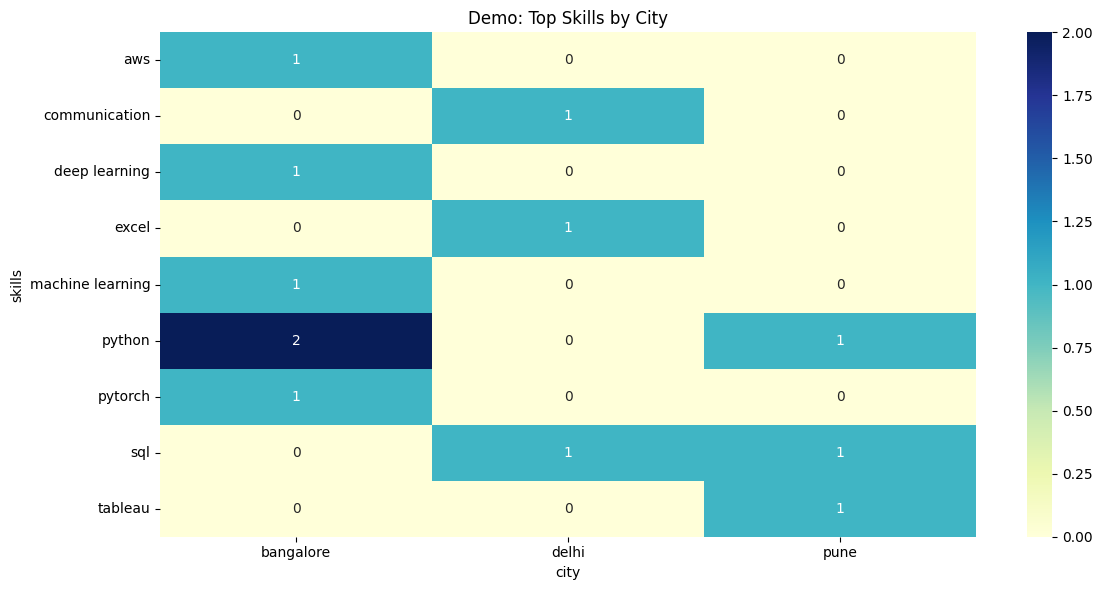

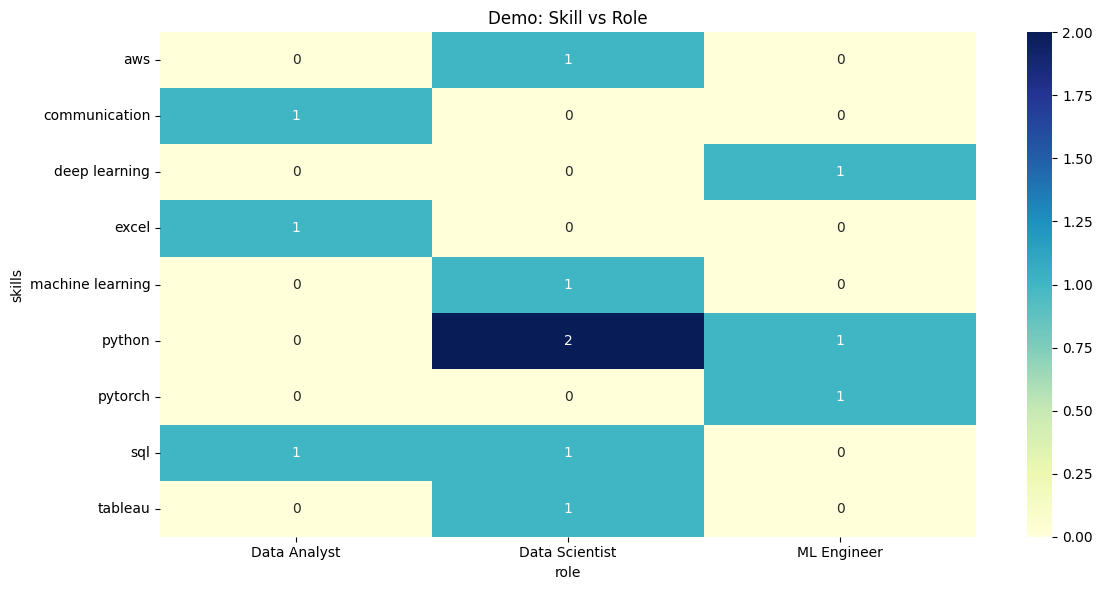


Demo - Top per city:
          city         skills  count
3   bangalore         python      2
0   bangalore            aws      1
1   bangalore  deep learning      1
5       delhi  communication      1
6       delhi          excel      1
7       delhi            sql      1
8        pune         python      1
9        pune            sql      1
10       pune        tableau      1

Demo - Top overall:
    skills  count
0  python      3
1     sql      2
2     aws      1
Exported analysis to: demo_linkedin_skill_analysis.xlsx


In [12]:
    # Run pipeline on sample
df_clean, df_exploded = build_skill_columns(sample)
pivot_city, _ = top_skills_by_city(df_exploded)
plot_heatmap(pivot_city, title="Demo: Top Skills by City")
pivot_role = skill_vs_role_matrix(df_exploded)
plot_heatmap(pivot_role, title="Demo: Skill vs Role")
top_per_city, top_overall = job_demand_recommendation(df_exploded)
print("\nDemo - Top per city:\n", top_per_city)
print("\nDemo - Top overall:\n", top_overall)
export_results_to_excel("demo_linkedin_skill_analysis.xlsx", pivot_city, pivot_role, top_per_city, top_overall, df_clean)
